In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model

import matplotlib.pyplot as plt
import numpy as np

import os

In [ ]:
!pip -q install kaggle

os.environ['KAGGLE_USERNAME'] = "yusufsyam"
os.environ['KAGGLE_KEY'] = "ef18b68f1885d208341d4aaee38056d9"

import kaggle

In [ ]:
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

100% 532M/534M [00:02<00:00, 258MB/s]
100% 534M/534M [00:02<00:00, 192MB/s]


In [ ]:
!unzip -q /content/vegetable-image-dataset.zip

In [ ]:
BASE_DIR= '/content/Vegetable Images'
BATCH_SIZE= 64
IMAGE_SIZE= (224, 224)
CLASS_LABELS= sorted(os.listdir(os.path.join(BASE_DIR, 'train')))

IMAGE_DIM= list(IMAGE_SIZE)
IMAGE_DIM.append(3)
IMAGE_DIM= tuple(IMAGE_DIM)

AUTOTUNE= tf.data.experimental.AUTOTUNE

In [ ]:
ds_train= keras.utils.image_dataset_from_directory(
    os.path.join(BASE_DIR, 'train'),
    batch_size= BATCH_SIZE,
    image_size= IMAGE_SIZE,
    shuffle= True
)

ds_validation= keras.utils.image_dataset_from_directory(
    os.path.join(BASE_DIR, 'validation'),
    batch_size= BATCH_SIZE,
    image_size= IMAGE_SIZE,
    shuffle= True
)

ds_test= keras.utils.image_dataset_from_directory(
    os.path.join(BASE_DIR, 'test'),
    batch_size= BATCH_SIZE,
    image_size= IMAGE_SIZE,
    shuffle= True
)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


In [ ]:
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.
    
    return image, label

In [ ]:
ds_train= ds_train.map(preprocess_image)
ds_validation= ds_validation.map(preprocess_image).cache('/').prefetch(AUTOTUNE)
ds_test= ds_test.map(preprocess_image).cache('/').prefetch(AUTOTUNE)

In [ ]:
def view_image(ds, class_labels=None, num_plot=(3,4), figsize=None):
    data = next(iter(ds))
    image = data[0].numpy()
    label = data[1].numpy()
    
    if figsize is None:
        figsize= (num_plot[1]*3, num_plot[0]*3)

    fig = plt.figure(figsize=figsize)

    for i in range(num_plot[0]*num_plot[1]):
        try:
            ax = fig.add_subplot(num_plot[0], num_plot[1], i+1, xticks=[], yticks=[])
            ax.imshow(image[i])
            ax.set_title(f"{class_labels[label[i]]}")
        except:
            pass

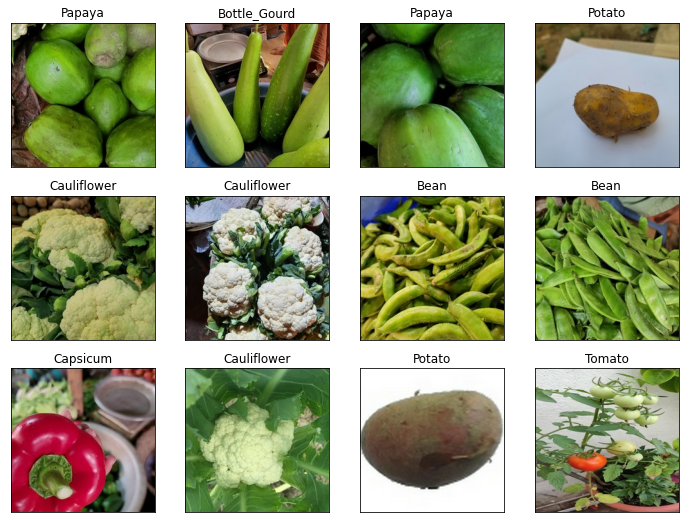

In [ ]:
view_image(ds_train, CLASS_LABELS)

In [ ]:
def augment(image, label):
    image = tf.image.random_brightness(image, max_delta=0.1)

    if tf.random.uniform((), minval=0, maxval=10, dtype=tf.int32) < 1:
        if tf.random.uniform((), minval=0, maxval=3, dtype=tf.int32) < 2:
            image= tf.image.random_saturation(image, lower=0.9, upper= 1.75)
        else:
            image= tf.tile(tf.image.rgb_to_grayscale(image),[1,1,1,3])

    # if tf.random.uniform((), minval=0, maxval=5, dtype=tf.int32) < 1:
    #     if tf.random.uniform((), minval=0, maxval=2, dtype=tf.int32) < 1:
    #         image= tf.image.resize(image, (tf.random.uniform((), minval=IMAGE_SIZE[0]//8*5, maxval= IMAGE_SIZE[0]-10, dtype=tf.int32), IMAGE_SIZE[1]))
    #     else:
    #         image= tf.image.resize(image, (IMAGE_SIZE[0], tf.random.uniform((), minval=IMAGE_SIZE[1]//8*5, maxval=IMAGE_SIZE[1]-10, dtype=tf.int32)))

    #     image= tf.image.resize_with_pad(image, IMAGE_SIZE[0], IMAGE_SIZE[1])

    image = tf.image.random_flip_left_right(image)
    image= tf.clip_by_value(image, 0, 1)

    return image, label

In [ ]:
ds_train= ds_train.map(augment, num_parallel_calls=AUTOTUNE).shuffle(150).cache('/').prefetch(AUTOTUNE)

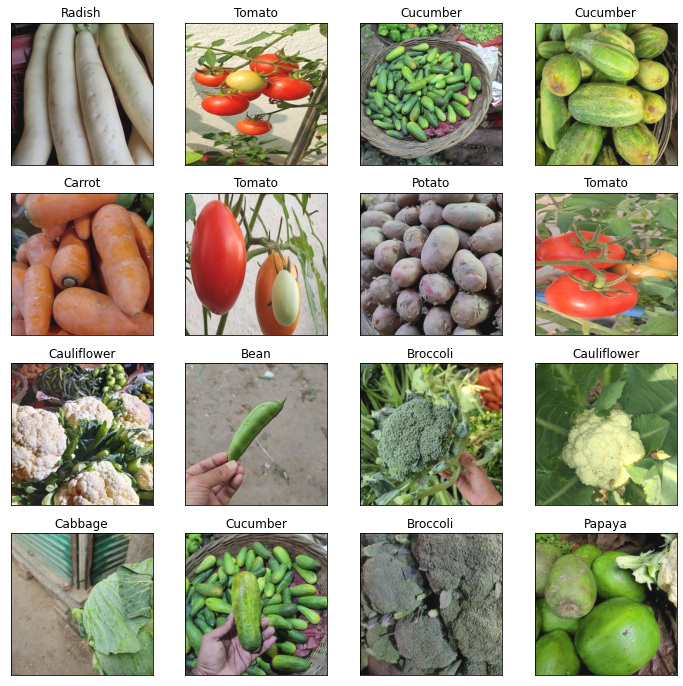

In [ ]:
view_image(ds_train, CLASS_LABELS, (4,4))

In [ ]:
class ResnetBlock(Model):
    def __init__(self, channels: int, down_sample=False):
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [ ]:
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir="tb_callback_dir", histogram_freq=1,
)

In [ ]:
model= ResNet18(len(CLASS_LABELS))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(ds_train, epochs= 10, validation_data=ds_validation, callbacks=[tensorboard_callback])

Epoch 1/10
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
235/235 [==============================] - 103s 301ms/step - loss: 0.9027 - accuracy: 0.7285 - val_loss: 5.1884 - val_accuracy: 0.2094
Epoch 2/10
235/235 [==============================] - 55s 235ms/step - loss: 0.3656 - accuracy: 0.8839 - val_loss: 1.1190 - val_accuracy: 0.6895
Epoch 3/10
235/235 [==============================] - 55s 234ms/step - loss: 0.2468 - accuracy: 0.9225 - val_loss: 0.8365 - val_accuracy: 0.7716
Epoch 4/10
235/235 [==============================] - 55s 234ms/step - loss: 0.1923 - accuracy: 0.9402 - val_loss: 3.1533 - val_accuracy: 0.4279
Epoch 5/10
235/235 [==============================] - 55s 233ms/step - loss: 0.1492 - accuracy: 0.9540 - val_loss: 0.7976 - val_accuracy: 0.8045


In [ ]:
model.evaluate(ds_train)

235/235 [==============================] - 105s 446ms/step - loss: 3.9921 - accuracy: 0.4774


[3.992144823074341, 0.477400004863739]

In [ ]:
!zip -r /content/tb_callback_dir.zip /content/tb_callback_dir

  adding: content/tb_callback_dir/ (stored 0%)
  adding: content/tb_callback_dir/train/ (stored 0%)
  adding: content/tb_callback_dir/train/events.out.tfevents.1658903897.94b043f2fc81.74.0.v2 (deflated 71%)
  adding: content/tb_callback_dir/validation/ (stored 0%)
  adding: content/tb_callback_dir/validation/events.out.tfevents.1658903986.94b043f2fc81.74.1.v2 (deflated 72%)


In [ ]:
from google.colab import files
files.download("/content/tb_callback_dir.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>